# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

from matplotlib.gridspec import GridSpec

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# make a mask mesh to show the bathymetry

In [3]:
# add files together for a whole year to make sure that every cell that COULD have flow, does
months = ['jan','mar','may','jul','sep','nov']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]

tran = np.array([])
depth = np.array([])
lon = np.array([])
for file in files:
    data = xr.open_dataset(file)
    tran = np.append(tran, data.init_transp)
    depth = np.append(depth, depthf(data.init_z-1.)[0])
    lon = np.append(lon, data.init_lon)

In [4]:
figrid = 377
lonW = 18
lonE = 63
maxdepth = 300

igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
    
t_lons = mymesh.glamt[0, igrid]
m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum())).values
t_dist = t_lons/m2lon
t_depths = mymesh.gdept_1d[0,:]
    
dist = lon/m2lon
      
H, xedges, yedges = np.histogram2d(dist, depth, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= tran)

H = np.where(H!=0,H,1)
Hmesh = np.where(H==1,H,np.nan)

Xmesh, Ymesh = np.meshgrid(xedges[:-1], yedges[:-1])

# Functions

In [5]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [6]:
def JRFluxCS(lonW, lonE, figrid, maxdepth, salfile, ax):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamf[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdepw_1d[0]
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    tick = 0.12
    vmax = tick/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)
    
    #get rid of lines from steps in CS
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[27,:] = H[27,:]/2
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2
    h = np.where(h>0, h, h*np.nan)
    
    cmap = cm.speed
    cmap.set_bad('white')

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cmap)
    
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[0, :, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))

    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12, fmt='%1.0f')
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+3], t_dist[lonE-3]])
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    mydata.close()

    return im, vmax, tick

In [14]:
def JRstdCS(lonW, lonE, figrid, maxdepth, file, ax, norm):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
        
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    w_depths = mymesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon

    data = xr.open_dataset(file)

    bins=[np.array(f_dist[lonW-1:lonE]), w_depths[0]]

        #bring in data by day
    start = np.arange(1,720,24) # want it only daily timescales bc dont care about tidal signal
    H = np.zeros([len(bins[0])-1,len(bins[1])-1,len(start)])
    for i in range(len(start)):
        lons = data.init_lon[(data.final_section != 0)&(data.init_t >= start[i])&(data.init_t <= start[i]+23)]
        dist = lons/m2lon
        depths = depthf(data.init_z[(data.final_section != 0)&(data.init_t >= start[i])&(data.init_t <= start[i]+23)]-1.)[0]
        transports = data.init_transp[(data.final_section != 0)&(data.init_t >= start[i])&(data.init_t <= start[i]+23)]/24

        H[:,:,i], xedges, yedges = np.histogram2d(dist, depths, bins=bins,weights= transports)

    # average H for division, don't want density = true here just want the straight transport through the cell
    time = 720
    lons = data.init_lon[(data.final_section != 0)]
    dist = lons/m2lon
    depths = depthf(data.init_z[(data.final_section != 0)]-1.)[0]
    transports = data.init_transp[(data.final_section != 0)]/time
    Htrans, _, _ = np.histogram2d(dist, depths, bins=bins,weights= transports)
    # get rif of any unreasonably low numbers
    Htrans = np.where(Htrans>5, Htrans, np.nan)

    if norm == True:
        std = (np.std(H,axis=2))/Htrans
        vmax = 4
    else:
        std = (np.std(H,axis=2))
        vmax = 200
    h= std
    h = np.where(h>0, h, h*np.nan)

    cmap = cm.amp
    cmap.set_bad('white')

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cmap)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(f_dist), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([f_dist[lonW+3], f_dist[lonE-3]])
    ax.set_xticklabels(['USA','Canada'], fontsize=12)
    ax.set_xlim((f_dist[lonW], f_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    data.close()

    return im

In [8]:
salJan18 = xr.open_dataset("/results2/SalishSea/nowcast-green.201905/15jan18/SalishSea_1d_20180115_20180115_grid_T.nc")
salMay18 = xr.open_dataset("/results2/SalishSea/nowcast-green.201905/15may18/SalishSea_1d_20180515_20180515_grid_T.nc")

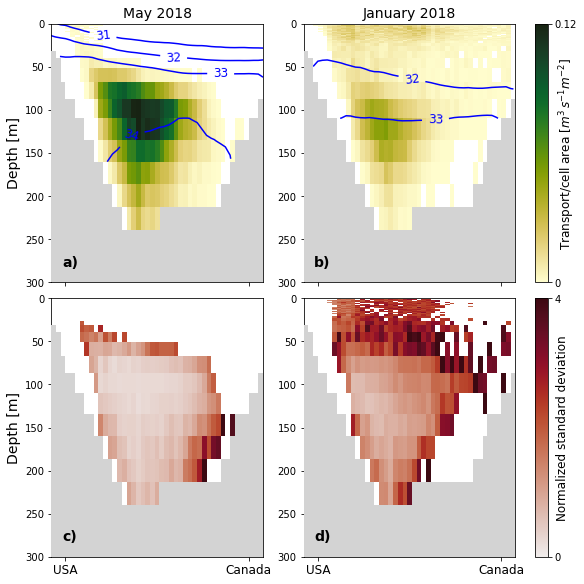

In [9]:
# removing some std cells with very little flow 

fig = plt.figure(constrained_layout=True, figsize=[8,8])
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
_,_,_= JRFluxCS(18, 63, 377, 300, salMay18, ax1)
_= JRstdCS( 18, 63, 377, 300, file, ax3, True)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
im, vmax, tick = JRFluxCS(18, 63, 377, 300, salJan18, ax2)
im2 = JRstdCS(18, 63, 377, 300, file, ax4, True)

# y and x labels
ax1.set_ylabel('Depth [m]', fontsize=14)
ax3.set_ylabel('Depth [m]', fontsize=14)

ax3.set_xticklabels(['USA','Canada'], fontsize=12)
ax4.set_xticklabels(['USA','Canada'], fontsize=12)
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# colourbar
# stev
cb1 = fig.colorbar(im2, ax=ax4)
cb1.set_ticks([0, 4])
cb1.set_label('Normalized standard deviation', labelpad=-5, fontsize=12)

# transport
cb1 = fig.colorbar(im, ax=ax2)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, tick]) 
cb1.set_label('Transport/cell area [$m^3 \, s^{-1} m^{-2}$]', labelpad=-20, fontsize=12)

#labels 
ax1.text(.05, .05, 'a)', ha='left', weight='bold', va='bottom', transform=ax1.transAxes, fontsize=14)
ax2.text(.05, .05, 'b)', ha='left', weight='bold', va='bottom', transform=ax2.transAxes, fontsize=14)
ax3.text(.05, .05, 'c)', ha='left', weight='bold', va='bottom', transform=ax3.transAxes, fontsize=14)
ax4.text(.05, .05, 'd)', ha='left', weight='bold', va='bottom', transform=ax4.transAxes, fontsize=14)

#titles
ax1.set_title('May 2018', fontsize=14)
ax2.set_title('January 2018', fontsize=14)

plt.savefig("./figures/CSfluxMayJan.pdf")

Text(0.5, 1.0, 'January 2018')

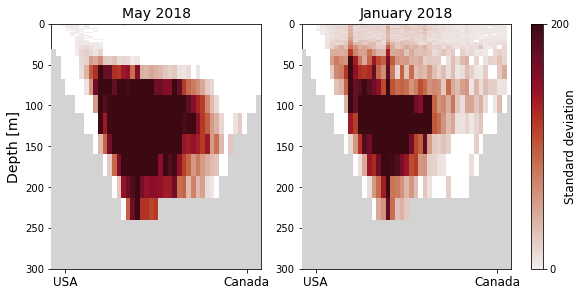

In [16]:
# removing some std cells with very little flow 

fig = plt.figure(constrained_layout=True, figsize=[8,4])
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
_= JRstdCS( 18, 63, 377, 300, file, ax1, False)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
im2 = JRstdCS(18, 63, 377, 300, file, ax2, False)

# y and x labels
ax1.set_ylabel('Depth [m]', fontsize=14)

ax1.set_xticklabels(['USA','Canada'], fontsize=12)
ax2.set_xticklabels(['USA','Canada'], fontsize=12)

# colourbar
# stev
cb1 = fig.colorbar(im2, ax=ax2)
cb1.set_ticks([0, 200])
cb1.set_label('Standard deviation', labelpad=-5, fontsize=12)

#titles
ax1.set_title('May 2018', fontsize=14)
ax2.set_title('January 2018', fontsize=14)

In [26]:
def JRFluxCS_loop(lonW, lonE, figrid, maxdepth, salfile, ax, title, inout):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    if inout == 'in':
        lons = mydata.init_lon[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]
        depths = depthf(mydata.init_z[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]-1.)[0]
        transports = mydata.init_transp[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]/time
    if inout == 'out':
        lons = mydata.final_lon[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]
        depths = depthf(mydata.final_z[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section == 0) & (abs(mydata.final_t-mydata.init_t) > 24)]/time
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    dist = lons/m2lon
    
    tick = 0.12
    vmax = tick/sum(transports)
#     vmax = .12/sum(transports)/m2lon
    
    H, xedges, yedges = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)
    
    #maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
    #not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2
    h = np.where(h>0, h, h*np.nan)
    
    cmap = cm.speed
    cmap.set_bad('white')

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cmap)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('$m^3 \, s^{-1} m^{-2}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[0, :, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))

    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12, fmt='%1.0f')
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)
    ax.contourf(Xmesh, Ymesh, Hmesh.T, [0.99, 1.01], colors='lightgray', zorder=3)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+3], t_dist[lonE-3]])
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_xticklabels(['USA','Canada'], fontsize=12)
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title), fontsize=16)
    mydata.close()

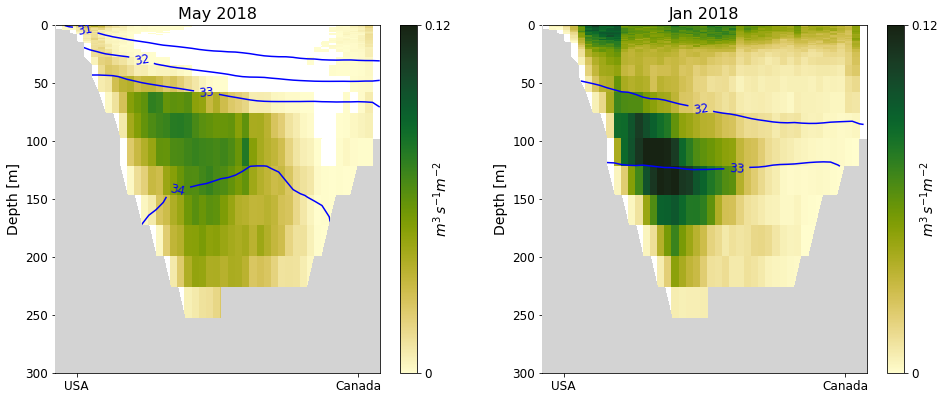

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,6.4))
plt.rcParams['font.size'] = 12


file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS_loop(18, 63, 377, 300, salMay18, ax[0], "May 2018",'in')

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS_loop(18, 63, 377, 300, salJan18, ax[1], "Jan 2018",'in')
plt.savefig("./figures/CSfluxMayJan_loopIn.pdf")

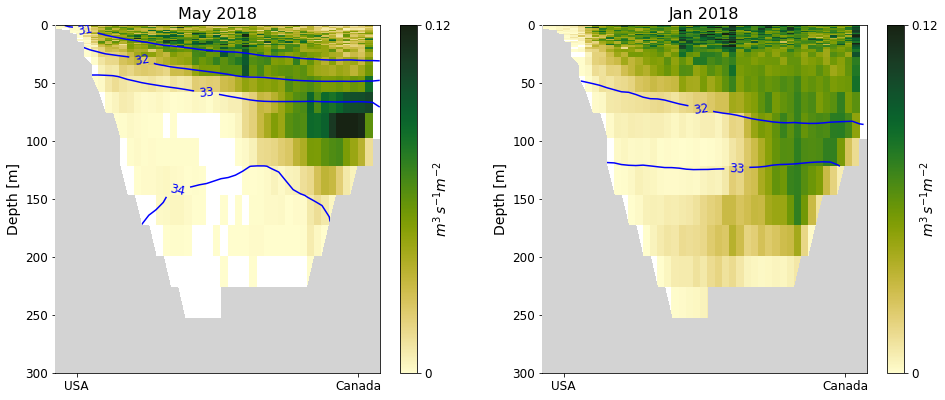

In [28]:
fig, ax = plt.subplots(1,2,figsize=(16,6.4))
plt.rcParams['font.size'] = 12

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS_loop(18, 63, 377, 300, salMay18, ax[0], "May 2018",'out')

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS_loop(18, 63, 377, 300, salJan18, ax[1], "Jan 2018",'out')
plt.savefig("./figures/CSfluxMayJan_loopIn.pdf")

In [10]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
jan_start = 1
mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))

In [24]:
# get data for winter 2016/17

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = (mar_end - jan_start + 1) + (dec_end - oct_start + 1) # need to divide by the FULL timespan you're looking at

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]/time
transportall1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport2 = mydata.init_transp[(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end) & (abs(mydata.init_t-mydata.final_t) > 24)]/time
transportall2 = mydata.init_transp[(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time
lon2 =  mydata['init_lon'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end) & (abs(mydata.init_t-mydata.final_t) > 24)]
depth2 =  mydata['init_depth'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end) & (abs(mydata.init_t-mydata.final_t) > 24)]

tranW16 = np.append(transport1, transport2)
tranallW16 = np.append(transportall1, transportall2)
lonW16 = np.append(lon1,lon2)
depthW16 = np.append(depth1,depth2)

print(np.sum(tranW16)/1000)
print(np.sum(tranallW16)/1000)

143.44769335559383
526.338801600678


In [25]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]/time
transportall1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end) & (abs(mydata.init_t-mydata.final_t) > 24)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
transport2 = []
transportall2 = []
lon2 = []
depth2 = []

for file in files:
    mydata = xr.open_dataset(file)
    transport2 = np.append(transport2, mydata.init_transp[(abs(mydata.init_t-mydata.final_t) > 24)]/time)
    lon2 = np.append(lon2, mydata['init_lon'][(abs(mydata.init_t-mydata.final_t) > 24)])
    depth2 = np.append(depth2, mydata['init_depth'][(abs(mydata.init_t-mydata.final_t) > 24)])
    
tranW17 = np.append(transport1, transport2)
tranallW17 = np.append(transportall1, transportall2)
lonW17 = np.append(lon1, lon2)
depthW17 = np.append(depth1, depth2)

print(np.sum(tranW17)/1000)
print(np.sum(tranallW17)/1000)

151.06672883626254
268.0376964284446


In [26]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = sep_end - apr_start +1

# tempS17 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
# saltS17 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
tranS17 = mydata.init_transp[(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end) & (abs(mydata.init_t-mydata.final_t) > 24)]/time
tranallS17 = mydata.init_transp[(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
lonS17 = mydata['init_lon'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end) & (abs(mydata.init_t-mydata.final_t) > 24)]
depthS17 = mydata['init_depth'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end) & (abs(mydata.init_t-mydata.final_t) > 24)]

print(np.sum(tranS17)/1000)
print(np.sum(tranallS17)/1000)

<xarray.DataArray 'init_transp' ()>
array(172.9165359)
<xarray.DataArray 'init_transp' ()>
array(530.04936998)


### Now lets make a nice lil histogram to look at the composition of the water and how it changes

##### we want to do this for allllll the years though

In [26]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

In [37]:
labels = ['2016','2017','2018','2019','2020']

In [28]:
def winter_months(variable, fall, spring):
    jan_start = 1
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    
    mar_end = 720+(spring*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(fall*720+(sum(yearjumps[:10]*24)))
    
    
#     time = 720
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2
    
    tracer = np.append(mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
    transport = np.append(mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time,mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time)
    depths = np.append(depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]-1.)[0],depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]-1.)[0])
    lons = np.append(mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
        
    return tracer, transport,lons, depths

In [29]:
def summer_months(variable, start, end):
    apr_start = 1+(start*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(end*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1
    
    tracer = mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
    transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
    depths = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]-1.)[0]
    lons = mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
        
    return tracer, transport,lons, depths

In [30]:
def winter_monthlies(variable, folder, yy, fall, spring): #not to be confused with winter_months - this is to do the same thimg but for runs done month by month
    time = 720
    month_max = ['jan', 'feb', 'mar', 'apr', 'sep', 'oct','nov', 'dec']
    months = month_max[:spring] + month_max[fall-4:]
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    jan_start = 1
    mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [31]:
def summer_monthlies(variable, folder, yy, start, end): #not to be confused with summer_months - this is to do the same thimg but for runs done month by month
    time = 720
    month_max = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
    months = month_max[start-2:end-2]
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [57]:
up_end = [8, 9, 8, 10, 9] #2016 = sep, 2017 = oct, 2018 = sep, 2019 = nov, 2020 = oct
up_start = [3, 4, 2, 3, 2] #2016 = apr, 2017 = may, 2018 = mar, 2019 = apr, 2020 = mar

fall_start = [8,9,8,10,9]
spr_end = [3,4,2,3,2]

In [33]:
#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
TtracerW16, transportW16, lonsW16, depthW16 = winter_months('init_temp', fall_start[0], spr_end[0])
TtracerS16, transportS16, lonsS16, depthS16 = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
TtracerW17, transportW17, lonsW17, depthW17 = winter_months('init_temp', fall_start[1], spr_end[1])
TtracerS17, transportS17, lonsS17, depthS17 = summer_months('init_temp', up_start[1], up_end[1])

#2018
TtracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_temp', '1hr', 18, fall_start[2], spr_end[2])
TtracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_temp', '1hr', 18, up_start[2], up_end[2])

#2019
TtracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_temp', '1hr', 19, fall_start[3], spr_end[3])
TtracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_temp', '1hr', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
TtracerW20, transportW20, lonsW20, depthW20 = winter_months('init_temp', fall_start[4], spr_end[4])
TtracerS20, transportS20, lonsS20, depthS20 = summer_months('init_temp', up_start[4], up_end[4])

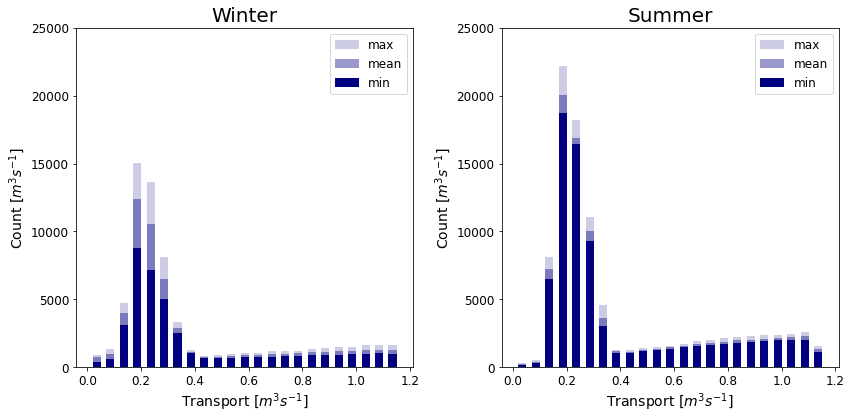

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.rcParams['font.size'] = 12
bins=np.arange(0.01,1.2,0.05)

#plt winter
jan_flux,x,_ = ax[0].hist([transportW16,transportW17,transportW18,transportW19,transportW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_flux,axis=0)
mini = np.min(jan_flux,axis=0)
maxi = np.max(jan_flux,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.03,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.03, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.03, color='navy',label='min')

ax[0].set_title('Winter', fontsize = 20)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_xlabel('Transport [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,25000])
ax[0].legend(fontsize = 12)

#plt may
may_flux,x,_ = ax[1].hist([transportS16,transportS17,transportS18,transportS19,transportS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_flux,axis=0)
mini = np.min(may_flux,axis=0)
maxi = np.max(may_flux,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.03,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.03, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.03, color='navy',label='min')

ax[1].set_title('Summer', fontsize = 20)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_xlabel('Transport [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,25000])
ax[1].legend(fontsize = 12)

plt.tight_layout()

In [48]:
#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
StracerW16, transportW16, lonsW16, depthW16 = winter_months('init_salt', fall_start[0], spr_end[0])
StracerS16, transportS16, lonsS16, depthS16 = summer_months('init_salt', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
StracerW17, transportW17, lonsW17, depthW17 = winter_months('init_salt', fall_start[1], spr_end[1])
StracerS17, transportS17, lonsS17, depthS17 = summer_months('init_salt', up_start[1], up_end[1])

#2018
StracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_salt', 'Car_Sal', 18, fall_start[2], spr_end[2])
StracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_salt', 'Car_Sal', 18, up_start[2], up_end[2])

#2019
StracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_salt', 'Car_Sal', 19, fall_start[3], spr_end[3])
StracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_salt', 'Car_Sal', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
StracerW20, transportW20, lonsW20, depthW20 = winter_months('init_salt', fall_start[4], spr_end[4])
StracerS20, transportS20, lonsS20, depthS20 = summer_months('init_salt', up_start[4], up_end[4])

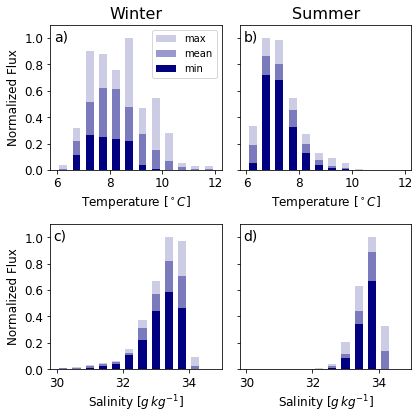

In [56]:
fig, ax = plt.subplots(2, 2, figsize = (6, 6))
plt.rcParams['font.size'] = 12

#TEMPERATURE
bins = np.arange(6,12.5,0.5)
#plt winter
jan_temp,x,_ = ax[0,0].hist([TtracerW16,TtracerW17,TtracerW18,TtracerW19,TtracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_temp,axis=0)/np.max(jan_temp)
mini = np.min(jan_temp,axis=0)/np.max(jan_temp)
maxi = np.max(jan_temp,axis=0)/np.max(jan_temp)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Winter', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend(fontsize = 10)

#plt may
may_temp,x,_ = ax[0,1].hist([TtracerS16,TtracerS17,TtracerS18,TtracerS19,TtracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_temp,axis=0)/np.max(may_temp)
mini = np.min(may_temp,axis=0)/np.max(may_temp)
maxi = np.max(may_temp,axis=0)/np.max(may_temp)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Summer', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#labels
ax[0,0].text(.02, .87, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .87, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)

#SALINITY
#plt winter
jan_sal,x,_ = ax[1,0].hist([StracerW16,StracerW17,StracerW18,StracerW19,StracerW20], bins=np.arange(30,35.1,0.4), weights= [transportW16,transportW17,transportW18,transportW19,transportW20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sal,axis=0)/np.max(jan_sal)
mini = np.min(jan_sal,axis=0)/np.max(jan_sal)
maxi = np.max(jan_sal,axis=0)/np.max(jan_sal)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,1.1])

#plt may
may_sal,x,_ = ax[1,1].hist([StracerS16,StracerS17,StracerS18,StracerS19,StracerS20], bins=np.arange(30,35.1,0.4), weights= [transportS16,transportS17,transportS18,transportS19,transportS20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sal,axis=0)/np.max(may_sal)
mini = np.min(may_sal,axis=0)/np.max(may_sal)
maxi = np.max(may_sal,axis=0)/np.max(may_sal)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,1.1])

#labels
ax[1,0].text(.02, .87, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .87, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)

plt.tight_layout()
# plt.savefig("./figures/physics_histograms.pdf")

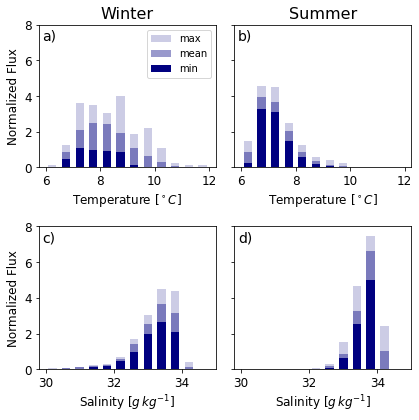

In [63]:
# normalised by mean seasonal flow instead of max

fig, ax = plt.subplots(2, 2, figsize = (6, 6))
plt.rcParams['font.size'] = 12
top = 8

#TEMPERATURE
bins = np.arange(6,12.5,0.5)
#plt winter
jan_temp,x,_ = ax[0,0].hist([TtracerW16,TtracerW17,TtracerW18,TtracerW19,TtracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_temp,axis=0)/np.mean(jan_temp)
mini = np.min(jan_temp,axis=0)/np.mean(jan_temp)
maxi = np.max(jan_temp,axis=0)/np.mean(jan_temp)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Winter', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,top])
ax[0,0].legend(fontsize = 10)

#plt may
may_temp,x,_ = ax[0,1].hist([TtracerS16,TtracerS17,TtracerS18,TtracerS19,TtracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_temp,axis=0)/np.mean(may_temp)
mini = np.min(may_temp,axis=0)/np.mean(may_temp)
maxi = np.max(may_temp,axis=0)/np.mean(may_temp)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Summer', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,top])
# ax[1].legend(fontsize = 12)

#labels
ax[0,0].text(.02, .87, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .87, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)

#SALINITY
#plt winter
jan_sal,x,_ = ax[1,0].hist([StracerW16,StracerW17,StracerW18,StracerW19,StracerW20], bins=np.arange(30,35.1,0.4), weights= [transportW16,transportW17,transportW18,transportW19,transportW20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sal,axis=0)/np.mean(jan_sal)
mini = np.min(jan_sal,axis=0)/np.mean(jan_sal)
maxi = np.max(jan_sal,axis=0)/np.mean(jan_sal)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,top])

#plt may
may_sal,x,_ = ax[1,1].hist([StracerS16,StracerS17,StracerS18,StracerS19,StracerS20], bins=np.arange(30,35.1,0.4), weights= [transportS16,transportS17,transportS18,transportS19,transportS20], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sal,axis=0)/np.mean(may_sal)
mini = np.min(may_sal,axis=0)/np.mean(may_sal)
maxi = np.max(may_sal,axis=0)/np.mean(may_sal)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,top])

#labels
ax[1,0].text(.02, .87, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .87, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)

plt.tight_layout()
plt.savefig("./figures/physics_histograms.pdf")

In [19]:
#CARBON
bins = np.arange(2000,2350,25)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, lonsW16, depthW16 = winter_months('init_temp', fall_start[0], spr_end[0])
tracerS16, transportS16, lonsS16, depthS16 = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, lonsW17, depthW17 = winter_months('init_temp', fall_start[1], spr_end[1])
tracerS17, transportS17, lonsS17, depthS17 = summer_months('init_temp', up_start[1], up_end[1])

#2018
tracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_temp', 'Car_Sal', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_temp', 'Car_Sal', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_temp', 'Car_Sal', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_temp', 'Car_Sal', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, lonsW20, depthW20 = winter_months('init_temp', fall_start[4], spr_end[4])
tracerS20, transportS20, lonsS20, depthS20 = summer_months('init_temp', up_start[4], up_end[4])

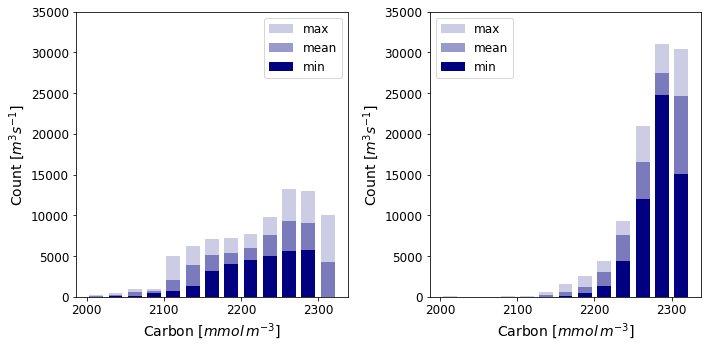

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_car,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_car,axis=0)
mini = np.min(jan_car,axis=0)
maxi = np.max(jan_car,axis=0)

ax[0].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=18, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Carbon [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,35000])
ax[0].legend(fontsize = 12)

#plt may
may_car,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_car,axis=0)
mini = np.min(may_car,axis=0)
maxi = np.max(may_car,axis=0)

ax[1].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=18, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Carbon [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,35000])
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/carbon_hystogram.pdf")

In [21]:
#NITRATE
bins = np.arange(5,35,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_temp', fall_start[0], spr_end[0])
tracerS16, transportS16, _, _ = summer_months('init_temp', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_temp', fall_start[1], spr_end[1])
tracerS17, transportS17, _, _ = summer_months('init_temp', up_start[1], up_end[1])

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_temp', fall_start[4], spr_end[4])
tracerS20, transportS20, _, _ = summer_months('init_temp', up_start[4], up_end[4])

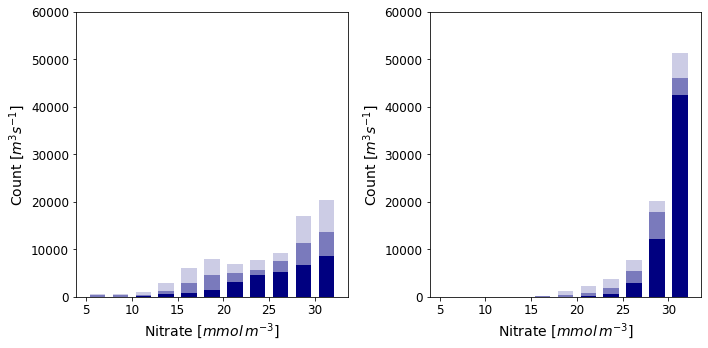

In [22]:

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_nit,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_nit,axis=0)
mini = np.min(jan_nit,axis=0)
maxi = np.max(jan_nit,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Nitrate [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,60000])
# ax[0].legend(fontsize = 12)

#plt may
may_nit,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_nit,axis=0)
mini = np.min(may_nit,axis=0)
maxi = np.max(may_nit,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Nitrate [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,60000])
# ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/nitrate_hystogram.pdf")

In [ ]:
#SILICON
bins = np.arange(20,50,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_salt', fall_start[0], spr_end[0])
tracerS16, transportS16, _, _ = summer_months('init_salt', up_start[0], up_end[0])

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_salt', fall_start[1], spr_end[1])
tracerS17, transportS17, _, _ = summer_months('init_salt', up_start[1], up_end[1])

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 18, fall_start[2], spr_end[2])
tracerS18, transportS18, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 18, up_start[2], up_end[2])

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 19, fall_start[3], spr_end[3])
tracerS19, transportS19, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 19, up_start[3], up_end[3])

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_salt', fall_start[4], spr_end[4])
tracerS20, transportS20, _, _ = summer_months('init_salt', up_start[4], up_end[4])

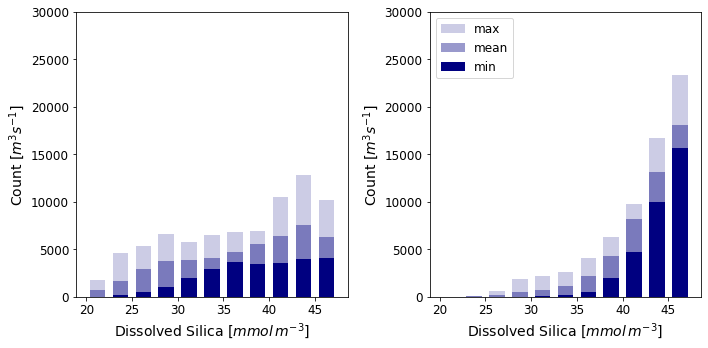

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

#plt winter
jan_sil,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sil,axis=0)
mini = np.min(jan_sil,axis=0)
maxi = np.max(jan_sil,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[0].set_title('Winter')
ax[0].set_xlabel('Dissolved Silica [$mmol \, m^{-3}$]', fontsize = 14)
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[0].set_ylim([0,30000])
# ax[0].legend(fontsize = 12)

#plt may
may_sil,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sil,axis=0)
mini = np.min(may_sil,axis=0)
maxi = np.max(may_sil,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

# ax[1].set_title('Summer')
ax[1].set_xlabel('Dissolved Silica [$mmol \, m^{-3}$]', fontsize = 14)
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]', fontsize = 14)
ax[1].set_ylim([0,30000])
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.savefig("./figures/silica_hystogram.pdf")

In [ ]:
def JRFluxSeason(lonW, lonE, figrid, maxdepth, ax, lons, transports, depths):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    
    vmax = .25/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths*-1, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)

#     maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
#     not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
#     im = ax.pcolormesh(X, Y, H.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))